In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from ffnn import FFNN

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.to_numpy(), mnist.target.astype(int).to_numpy()

# Take a subset for faster experimentation
X_subset = X[:5000]
y_subset = y[:5000]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape for the FFNN input format (features x samples)
X_train = X_train.T
X_test = X_test.T

# Define a function to one-hot encode labels
def one_hot_encode(y, n_classes=None):
    if n_classes is None:
        n_classes = int(np.max(y) + 1)
    
    y_one_hot = np.zeros((y.size, n_classes))
    y_one_hot[np.arange(y.size), y.astype(int)] = 1
    
    return y_one_hot

# One-hot encode the labels
y_train_one_hot = one_hot_encode(y_train, n_classes=10).T
y_test_one_hot = one_hot_encode(y_test, n_classes=10).T

Loading MNIST dataset...


In [3]:
# Define a function to evaluate the model
def evaluate_model(model, X, y_true, y_one_hot):
    # Forward pass to get predictions
    y_pred_proba = model.predict(X)
    
    # Convert to class predictions
    y_pred = np.argmax(y_pred_proba, axis=0)
    
    # Convert one-hot true values to class indices
    if y_true.shape[0] != y_one_hot.shape[0]:  # If y_true is not already in class format
        y_true = np.argmax(y_one_hot, axis=0)
    
    # Compute accuracy
    accuracy = np.mean(y_pred == y_true)
    
    return accuracy, y_pred


Experiment: Depth and Width

Training Shallow network...
Epoch 1/20 - loss: 2.5812 - val_loss: 2.5120
Epoch 2/20 - loss: 2.4181 - val_loss: 2.3724
Epoch 3/20 - loss: 2.3024 - val_loss: 2.2695
Epoch 4/20 - loss: 2.2144 - val_loss: 2.1889
Epoch 5/20 - loss: 2.1436 - val_loss: 2.1226
Epoch 6/20 - loss: 2.0842 - val_loss: 2.0664
Epoch 7/20 - loss: 2.0329 - val_loss: 2.0170
Epoch 8/20 - loss: 1.9872 - val_loss: 1.9728
Epoch 9/20 - loss: 1.9458 - val_loss: 1.9325
Epoch 10/20 - loss: 1.9075 - val_loss: 1.8950
Epoch 11/20 - loss: 1.8718 - val_loss: 1.8599
Epoch 12/20 - loss: 1.8379 - val_loss: 1.8266
Epoch 13/20 - loss: 1.8057 - val_loss: 1.7949
Epoch 14/20 - loss: 1.7748 - val_loss: 1.7647
Epoch 15/20 - loss: 1.7452 - val_loss: 1.7356
Epoch 16/20 - loss: 1.7166 - val_loss: 1.7075
Epoch 17/20 - loss: 1.6890 - val_loss: 1.6804
Epoch 18/20 - loss: 1.6623 - val_loss: 1.6543
Epoch 19/20 - loss: 1.6365 - val_loss: 1.6290
Epoch 20/20 - loss: 1.6115 - val_loss: 1.6046
Shallow network accuracy: 0.534

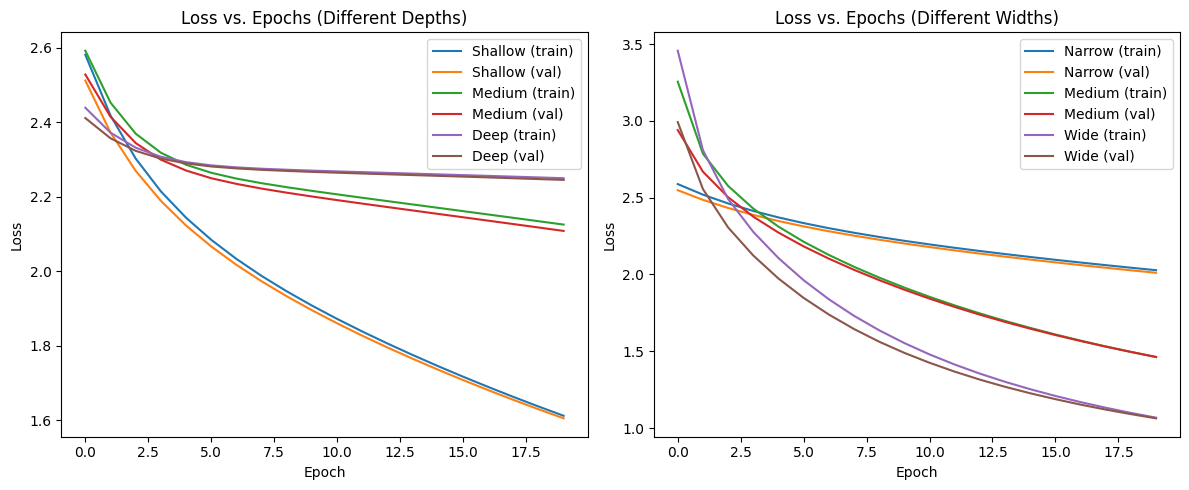

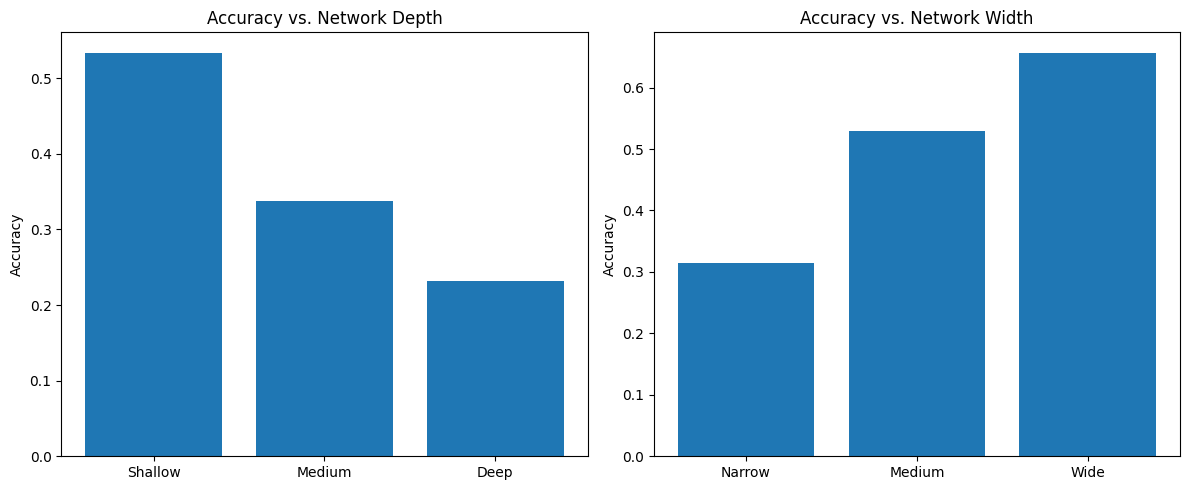

In [4]:
# Experiment 1: Depth and Width
def experiment_depth_width():
    print("\nExperiment: Depth and Width")
    
    # Fixed width, varying depth
    depth_configs = [
        {"name": "Shallow", "layers": [784, 30, 10], "activations": ["sigmoid", "softmax"]},
        {"name": "Medium", "layers": [784, 30, 30, 10], "activations": ["sigmoid", "sigmoid", "softmax"]},
        {"name": "Deep", "layers": [784, 30, 30, 30, 10], "activations": ["sigmoid", "sigmoid", "sigmoid", "softmax"]}
    ]
    
    # Fixed depth, varying width
    width_configs = [
        {"name": "Narrow", "layers": [784, 10, 10], "activations": ["sigmoid", "softmax"]},
        {"name": "Medium", "layers": [784, 50, 10], "activations": ["sigmoid", "softmax"]},
        {"name": "Wide", "layers": [784, 100, 10], "activations": ["sigmoid", "softmax"]}
    ]
    
    # Train and evaluate models with different depths
    depth_histories = {}
    depth_accuracies = {}
    
    for config in depth_configs:
        print(f"\nTraining {config['name']} network...")
        model = FFNN(
            layer_sizes=config['layers'],
            activation_functions=config['activations'],
            loss_function='categorical_crossentropy',
            weight_init_method='random_normal',
            weight_init_params={'mean': 0, 'variance': 0.1, 'seed': 42}
        )
        
        history = model.train(
            X_train, y_train_one_hot,
            X_val=X_test, y_val=y_test_one_hot,
            batch_size=32, learning_rate=0.1,
            epochs=20, verbose=1
        )
        
        accuracy, _ = evaluate_model(model, X_test, y_test, y_test_one_hot)
        print(f"{config['name']} network accuracy: {accuracy:.4f}")
        
        depth_histories[config['name']] = history
        depth_accuracies[config['name']] = accuracy
    
    # Train and evaluate models with different widths
    width_histories = {}
    width_accuracies = {}
    
    for config in width_configs:
        print(f"\nTraining {config['name']} network...")
        model = FFNN(
            layer_sizes=config['layers'],
            activation_functions=config['activations'],
            loss_function='categorical_crossentropy',
            weight_init_method='random_normal',
            weight_init_params={'mean': 0, 'variance': 0.1, 'seed': 42}
        )
        
        history = model.train(
            X_train, y_train_one_hot,
            X_val=X_test, y_val=y_test_one_hot,
            batch_size=32, learning_rate=0.1,
            epochs=20, verbose=1
        )
        
        accuracy, _ = evaluate_model(model, X_test, y_test, y_test_one_hot)
        print(f"{config['name']} network accuracy: {accuracy:.4f}")
        
        width_histories[config['name']] = history
        width_accuracies[config['name']] = accuracy
    
    # Plot loss curves for different depths
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, history in depth_histories.items():
        plt.plot(history['train_loss'], label=f"{name} (train)")
        plt.plot(history['val_loss'], label=f"{name} (val)")
    plt.title("Loss vs. Epochs (Different Depths)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot loss curves for different widths
    plt.subplot(1, 2, 2)
    for name, history in width_histories.items():
        plt.plot(history['train_loss'], label=f"{name} (train)")
        plt.plot(history['val_loss'], label=f"{name} (val)")
    plt.title("Loss vs. Epochs (Different Widths)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    names = list(depth_accuracies.keys())
    accuracies = [depth_accuracies[name] for name in names]
    plt.bar(names, accuracies)
    plt.title("Accuracy vs. Network Depth")
    plt.ylabel("Accuracy")
    
    plt.subplot(1, 2, 2)
    names = list(width_accuracies.keys())
    accuracies = [width_accuracies[name] for name in names]
    plt.bar(names, accuracies)
    plt.title("Accuracy vs. Network Width")
    plt.ylabel("Accuracy")
    
    plt.tight_layout()
    plt.show()
    
experiment_depth_width()


Experiment: Activation Functions

Training network with Linear activation...
Epoch 1/20 - loss: 11.7655 - val_loss: 6.4498
Epoch 2/20 - loss: 4.6335 - val_loss: 4.0060
Epoch 3/20 - loss: 3.1049 - val_loss: 3.1609
Epoch 4/20 - loss: 2.4470 - val_loss: 2.7319
Epoch 5/20 - loss: 2.0627 - val_loss: 2.4774
Epoch 6/20 - loss: 1.7955 - val_loss: 2.3043
Epoch 7/20 - loss: 1.5902 - val_loss: 2.1900
Epoch 8/20 - loss: 1.4324 - val_loss: 2.1146
Epoch 9/20 - loss: 1.3101 - val_loss: 2.0065
Epoch 10/20 - loss: 1.2083 - val_loss: 1.9410
Epoch 11/20 - loss: 1.1220 - val_loss: 1.8660
Epoch 12/20 - loss: 1.0450 - val_loss: 1.8301
Epoch 13/20 - loss: 0.9772 - val_loss: 1.7693
Epoch 14/20 - loss: 0.9155 - val_loss: 1.7306
Epoch 15/20 - loss: 0.8670 - val_loss: 1.6982
Epoch 16/20 - loss: 0.8183 - val_loss: 1.6599
Epoch 17/20 - loss: 0.7746 - val_loss: 1.6401
Epoch 18/20 - loss: 0.7389 - val_loss: 1.5963
Epoch 19/20 - loss: 0.7033 - val_loss: 1.5744
Epoch 20/20 - loss: 0.6732 - val_loss: 1.5451
Linear act

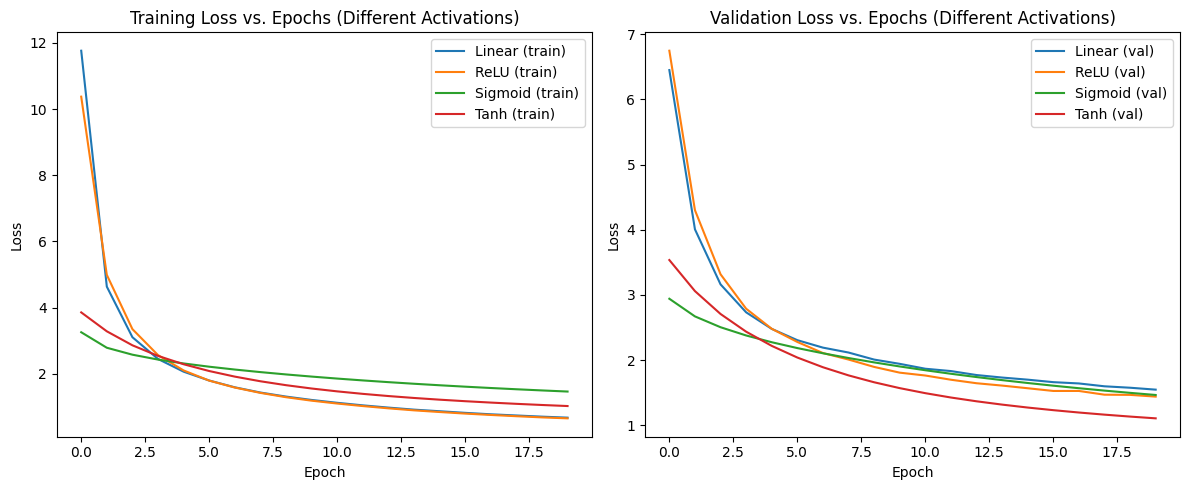

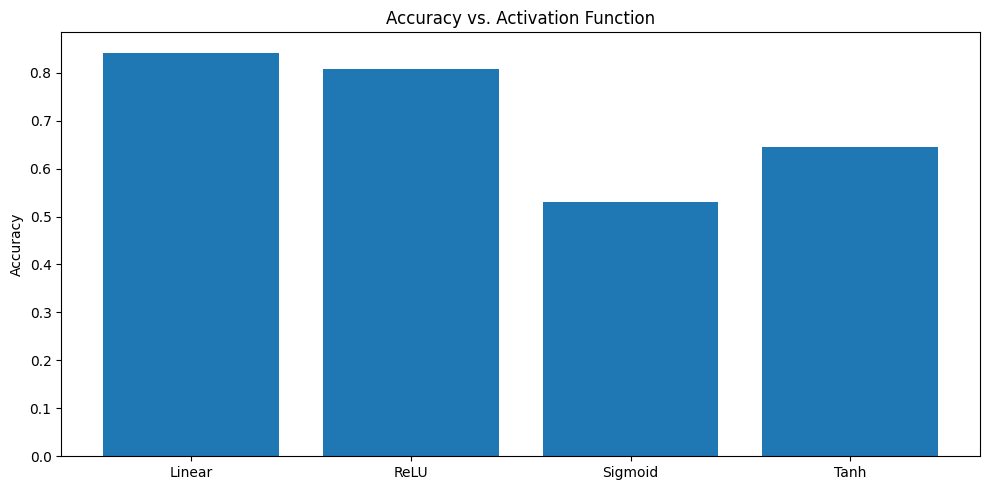


Weight and gradient distributions for Linear activation:


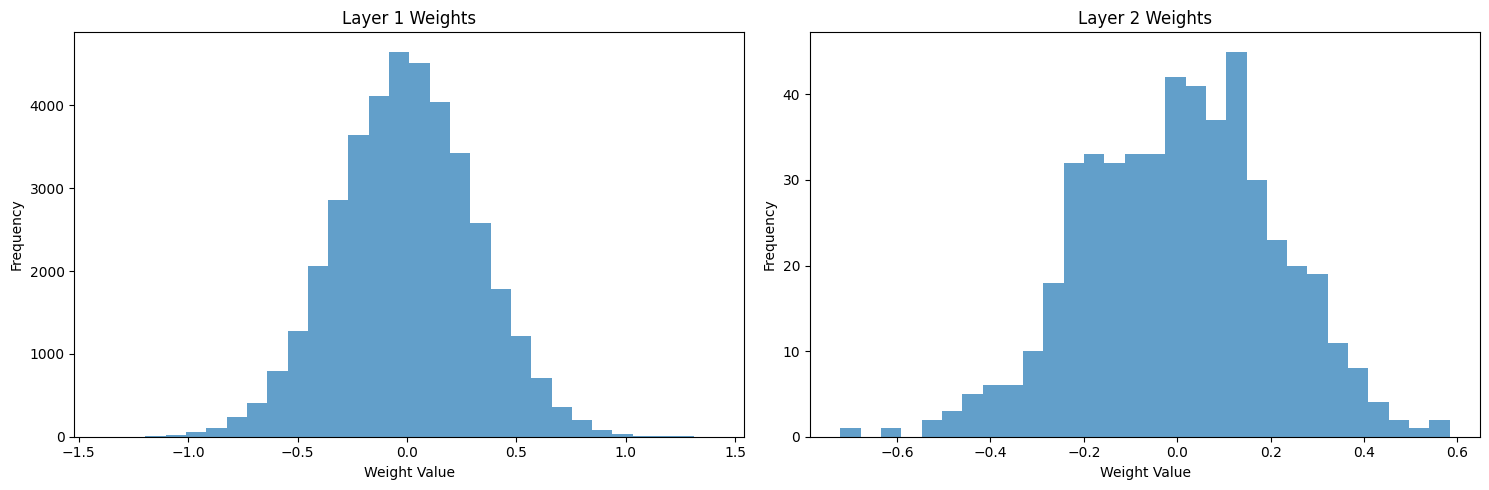

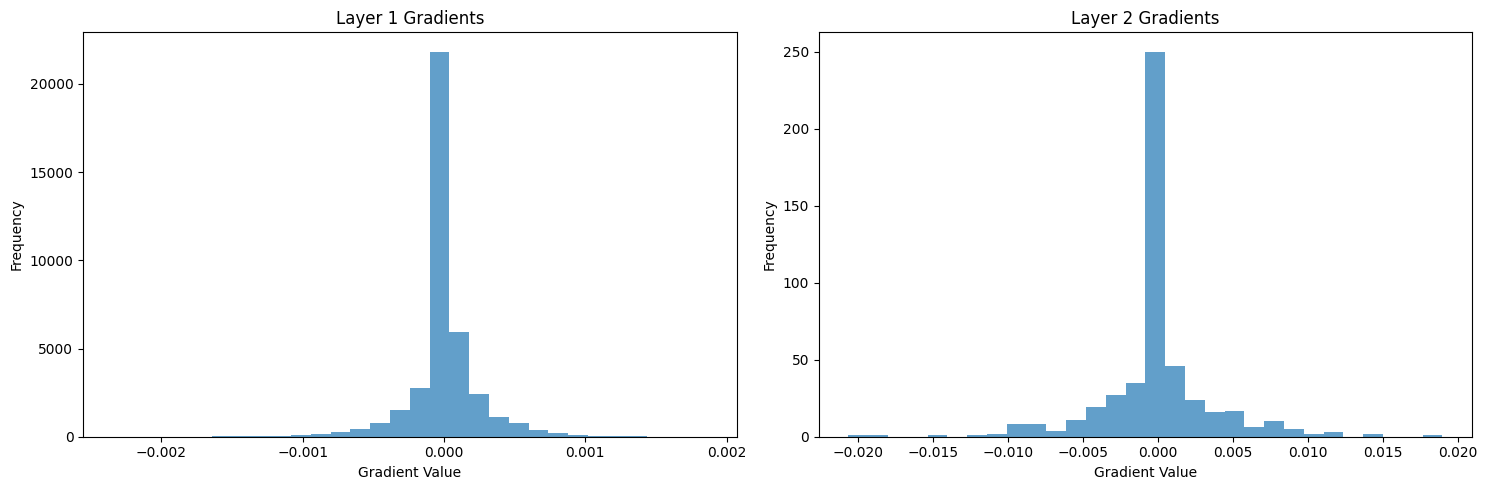


Weight and gradient distributions for ReLU activation:


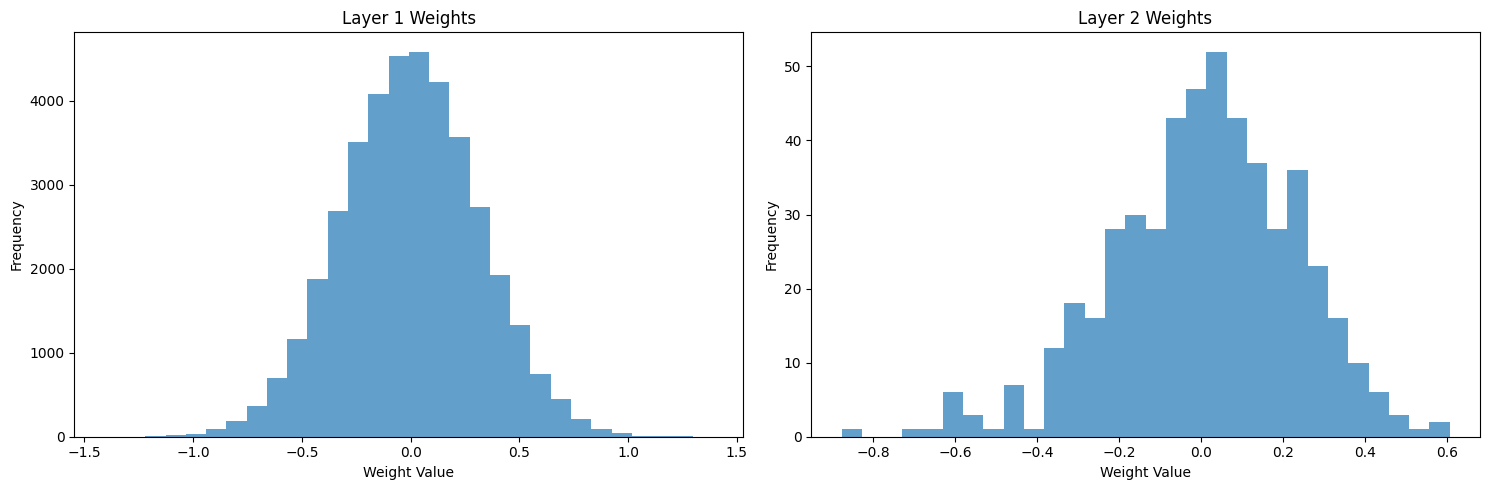

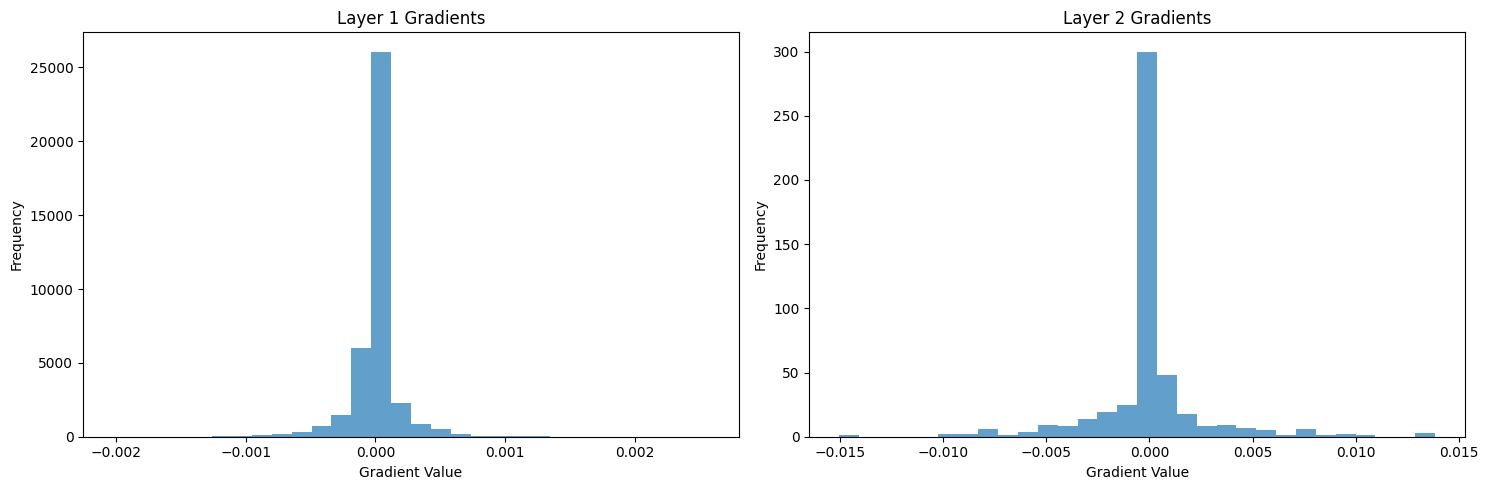


Weight and gradient distributions for Sigmoid activation:


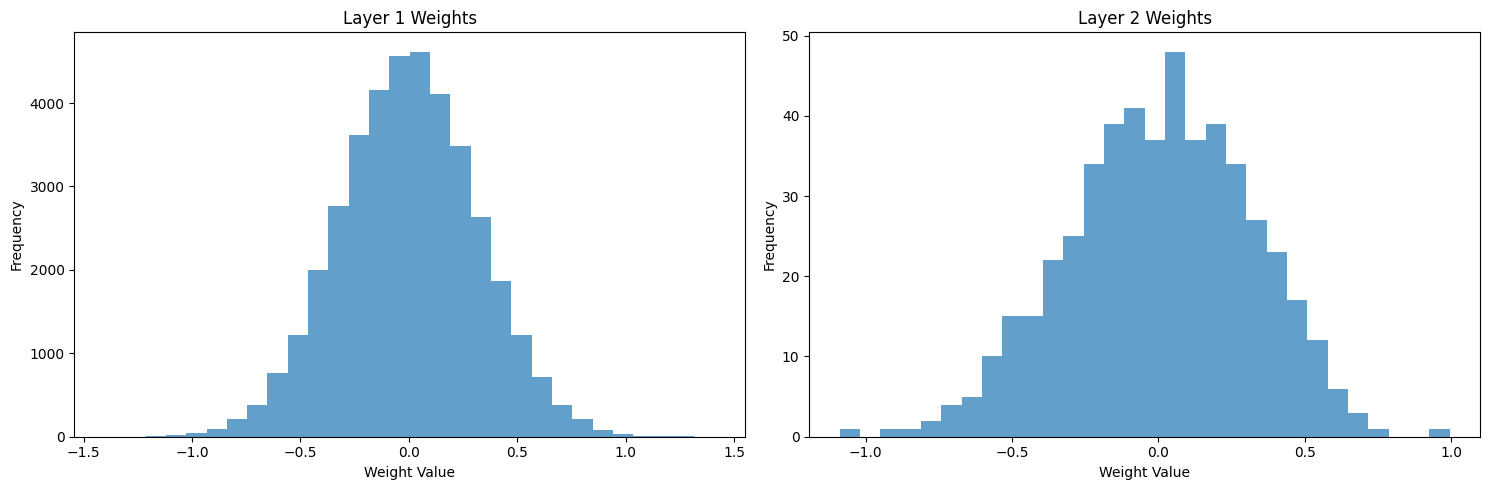

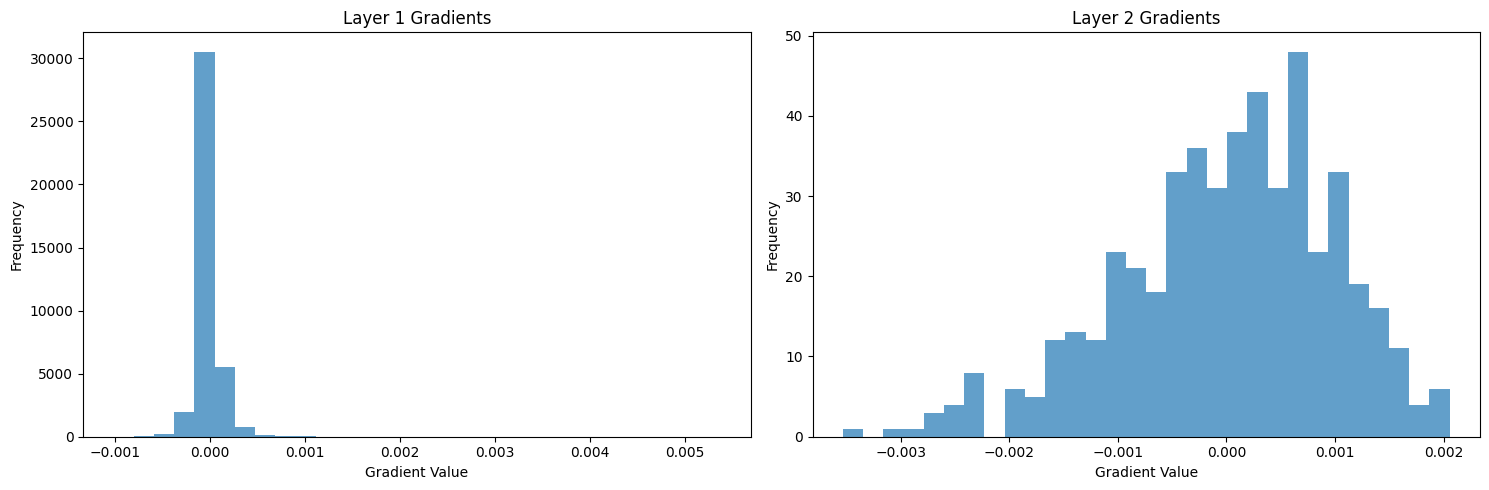


Weight and gradient distributions for Tanh activation:


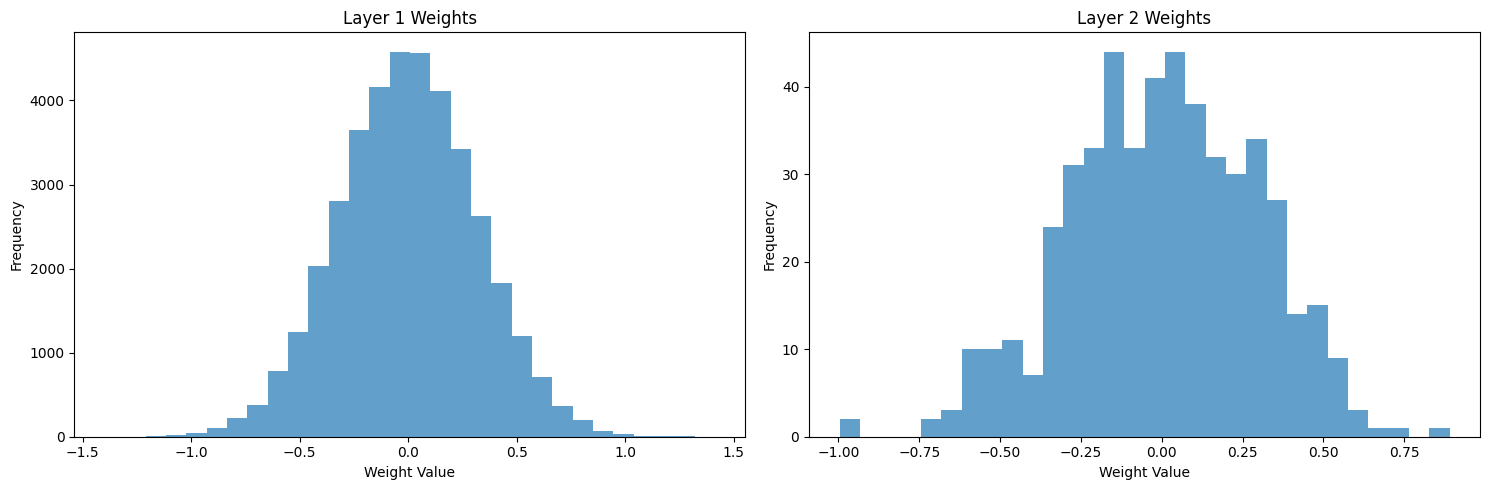

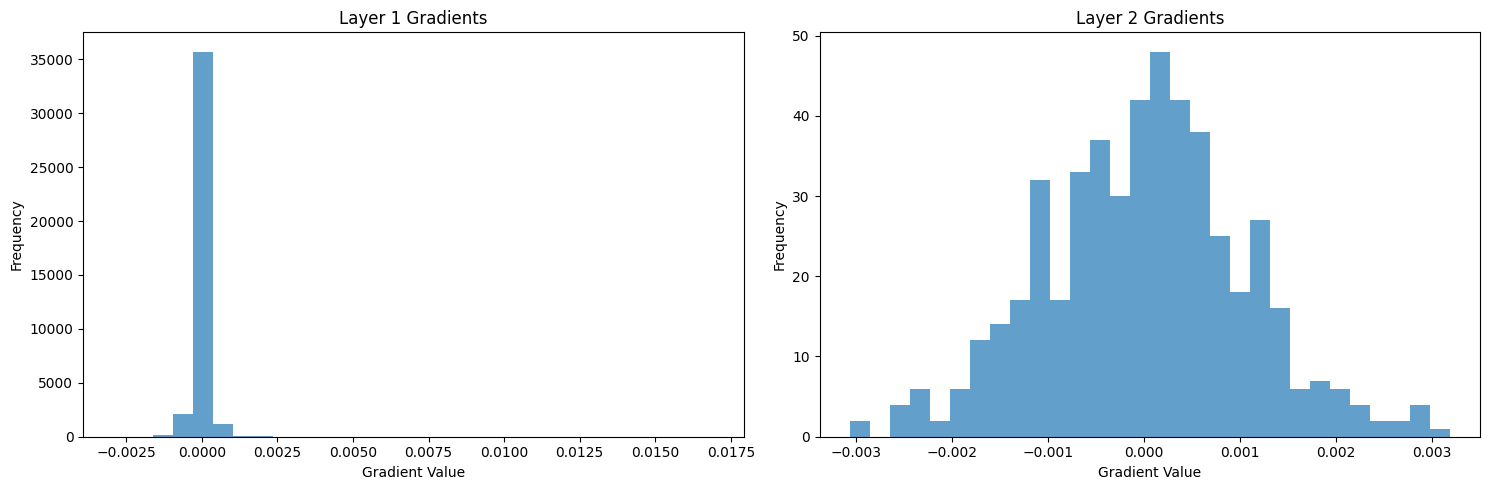

In [5]:
# Experiment 2: Activation Functions
def experiment_activation_functions():
    print("\nExperiment: Activation Functions")
    
    activation_configs = [
        {"name": "Linear", "activation": "linear"},
        {"name": "ReLU", "activation": "relu"},
        {"name": "Sigmoid", "activation": "sigmoid"},
        {"name": "Tanh", "activation": "tanh"}
    ]
    
    activation_histories = {}
    activation_accuracies = {}
    activation_models = {}
    
    for config in activation_configs:
        print(f"\nTraining network with {config['name']} activation...")
        model = FFNN(
            layer_sizes=[784, 50, 10],
            activation_functions=[config['activation'], "softmax"],
            loss_function='categorical_crossentropy',
            weight_init_method='random_normal',
            weight_init_params={'mean': 0, 'variance': 0.1, 'seed': 42}
        )
        
        history = model.train(
            X_train, y_train_one_hot,
            X_val=X_test, y_val=y_test_one_hot,
            batch_size=32, learning_rate=0.1,
            epochs=20, verbose=1
        )
        
        accuracy, _ = evaluate_model(model, X_test, y_test, y_test_one_hot)
        print(f"{config['name']} activation accuracy: {accuracy:.4f}")
        
        activation_histories[config['name']] = history
        activation_accuracies[config['name']] = accuracy
        activation_models[config['name']] = model
    
    # Plot loss curves for different activation functions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, history in activation_histories.items():
        plt.plot(history['train_loss'], label=f"{name} (train)")
    plt.title("Training Loss vs. Epochs (Different Activations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name, history in activation_histories.items():
        plt.plot(history['val_loss'], label=f"{name} (val)")
    plt.title("Validation Loss vs. Epochs (Different Activations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 5))
    names = list(activation_accuracies.keys())
    accuracies = [activation_accuracies[name] for name in names]
    plt.bar(names, accuracies)
    plt.title("Accuracy vs. Activation Function")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    # Plot weight and gradient distributions for each activation function
    for name, model in activation_models.items():
        print(f"\nWeight and gradient distributions for {name} activation:")
        
        # Plot weight distributions for all layers
        model.plot_weight_distribution()
        
        # Plot gradient distributions for all layers
        model.plot_gradient_distribution()
        
experiment_activation_functions()


Experiment: Learning Rate

Training network with learning rate = 0.001...
Epoch 1/20 - loss: 3.7901 - val_loss: 3.8197
Epoch 2/20 - loss: 3.7716 - val_loss: 3.8007
Epoch 3/20 - loss: 3.7534 - val_loss: 3.7820
Epoch 4/20 - loss: 3.7356 - val_loss: 3.7638
Epoch 5/20 - loss: 3.7181 - val_loss: 3.7458
Epoch 6/20 - loss: 3.7010 - val_loss: 3.7283
Epoch 7/20 - loss: 3.6842 - val_loss: 3.7110
Epoch 8/20 - loss: 3.6678 - val_loss: 3.6942
Epoch 9/20 - loss: 3.6517 - val_loss: 3.6776
Epoch 10/20 - loss: 3.6359 - val_loss: 3.6614
Epoch 11/20 - loss: 3.6204 - val_loss: 3.6454
Epoch 12/20 - loss: 3.6052 - val_loss: 3.6298
Epoch 13/20 - loss: 3.5903 - val_loss: 3.6145
Epoch 14/20 - loss: 3.5757 - val_loss: 3.5995
Epoch 15/20 - loss: 3.5614 - val_loss: 3.5848
Epoch 16/20 - loss: 3.5474 - val_loss: 3.5704
Epoch 17/20 - loss: 3.5336 - val_loss: 3.5563
Epoch 18/20 - loss: 3.5202 - val_loss: 3.5424
Epoch 19/20 - loss: 3.5069 - val_loss: 3.5288
Epoch 20/20 - loss: 3.4940 - val_loss: 3.5155
Learning rate 

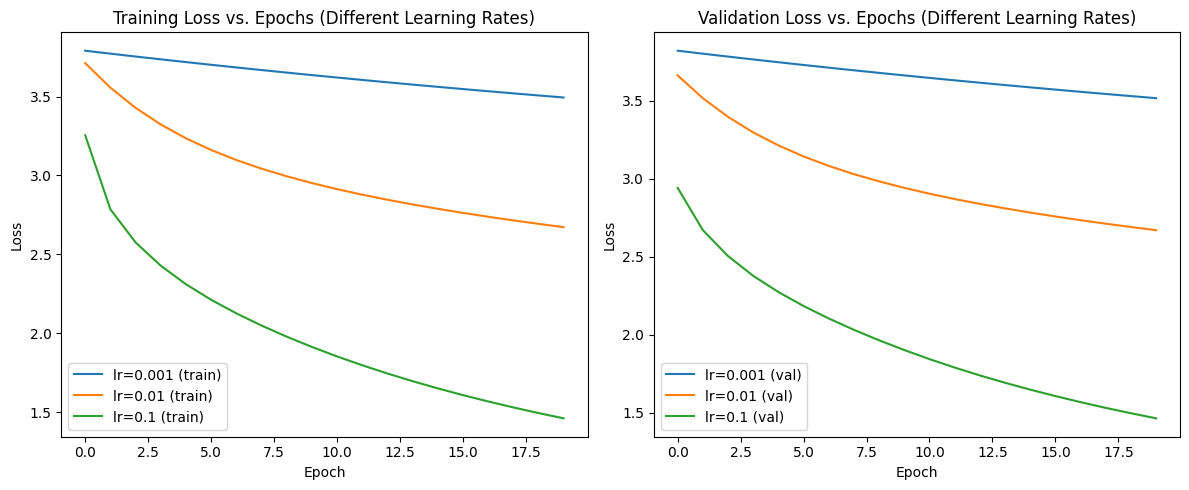

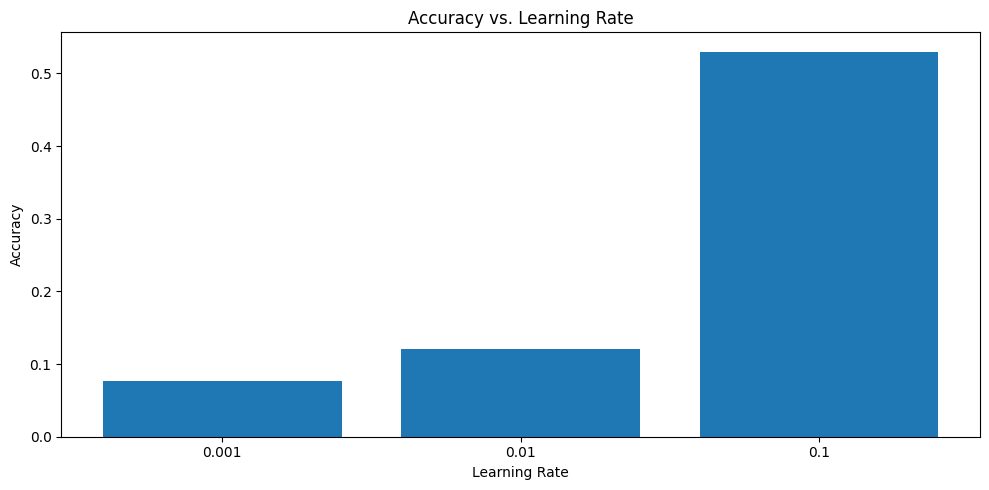


Weight and gradient distributions for learning rate = 0.001:


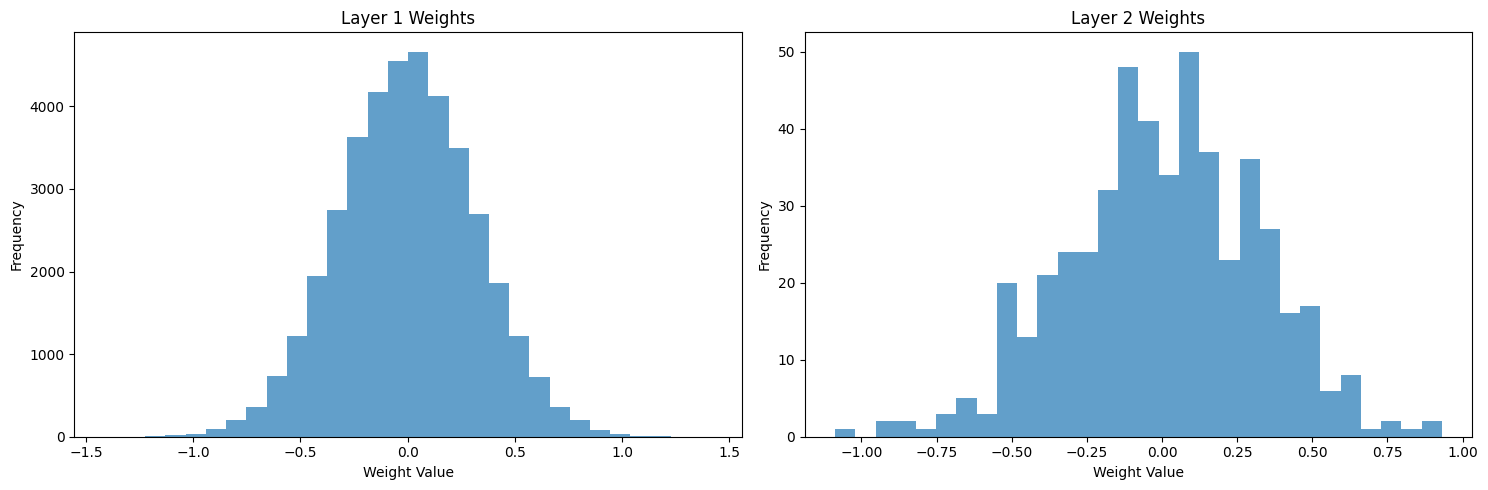

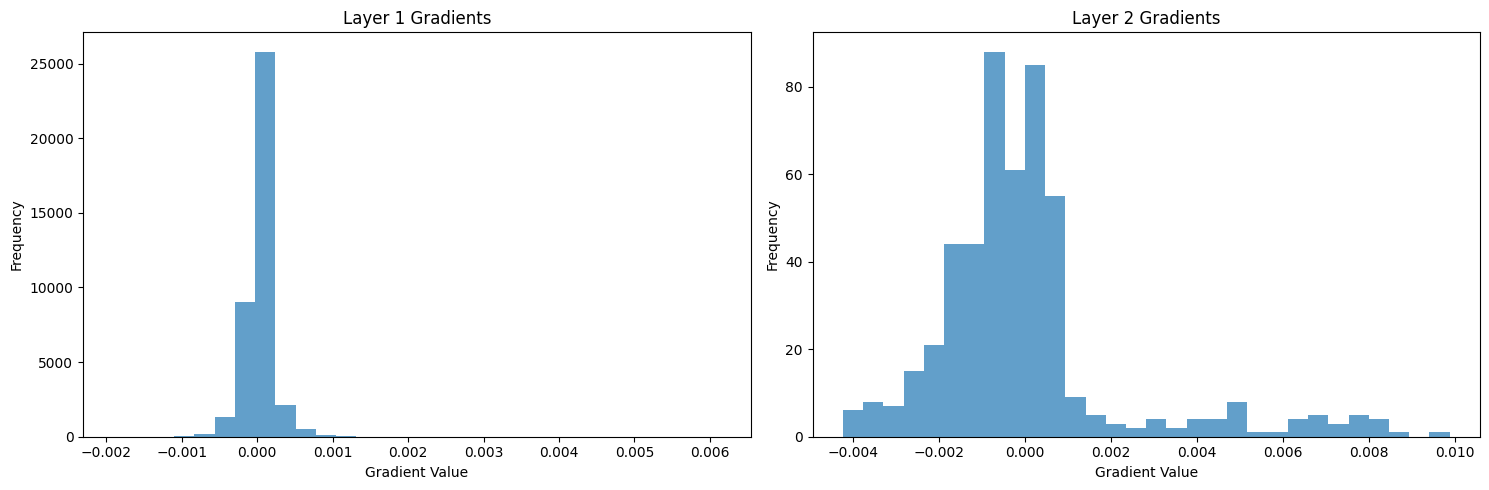


Weight and gradient distributions for learning rate = 0.01:


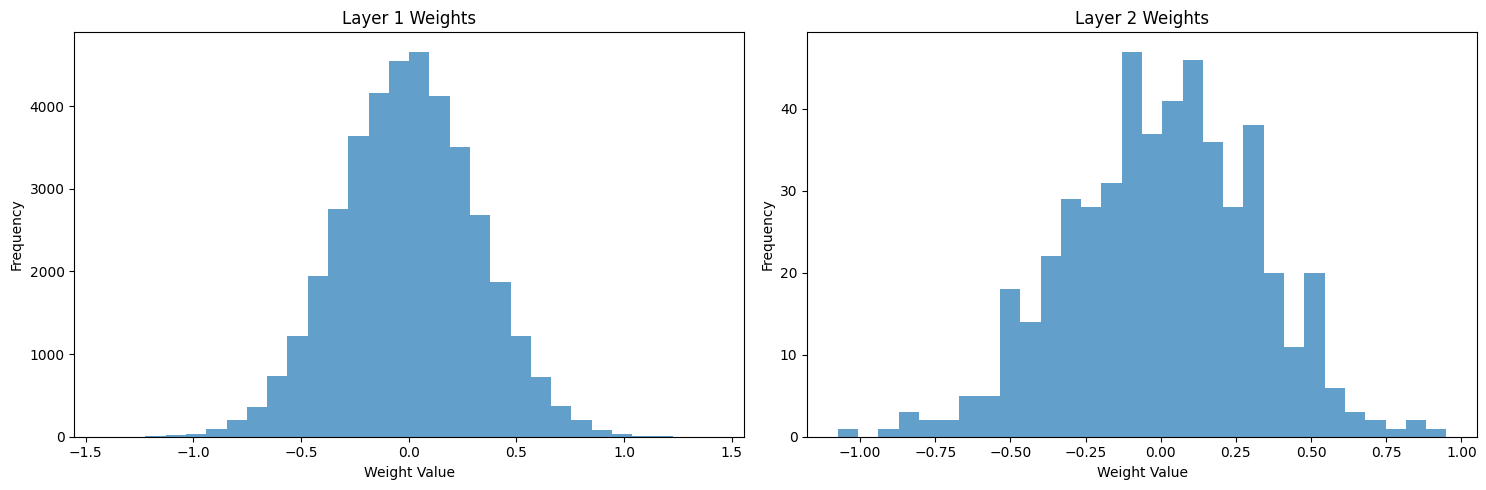

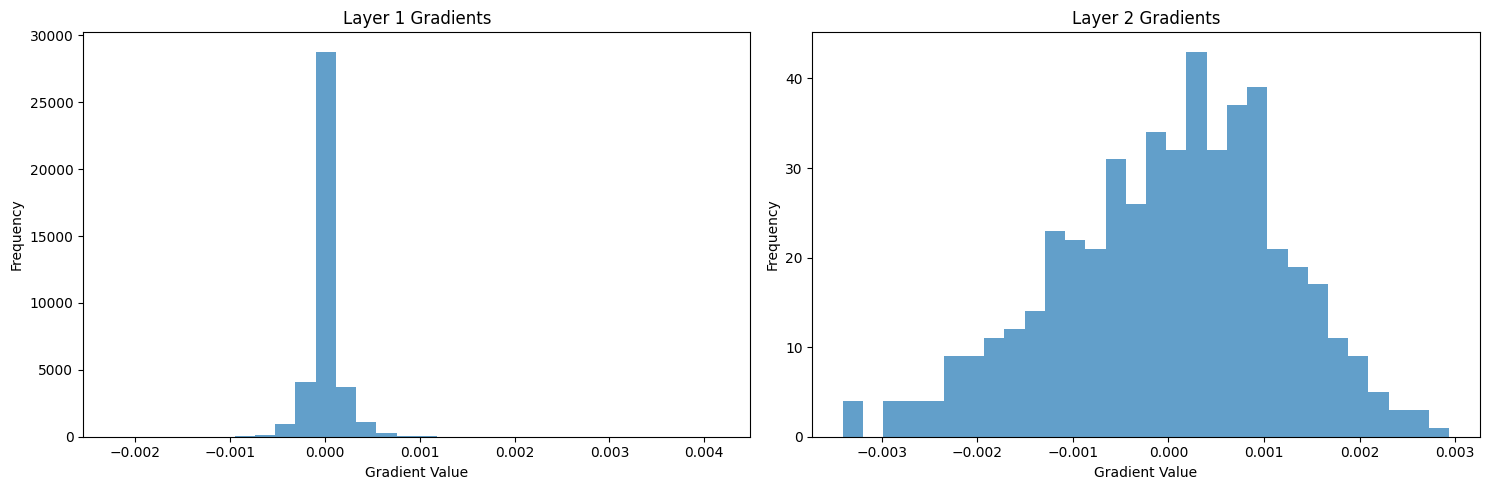


Weight and gradient distributions for learning rate = 0.1:


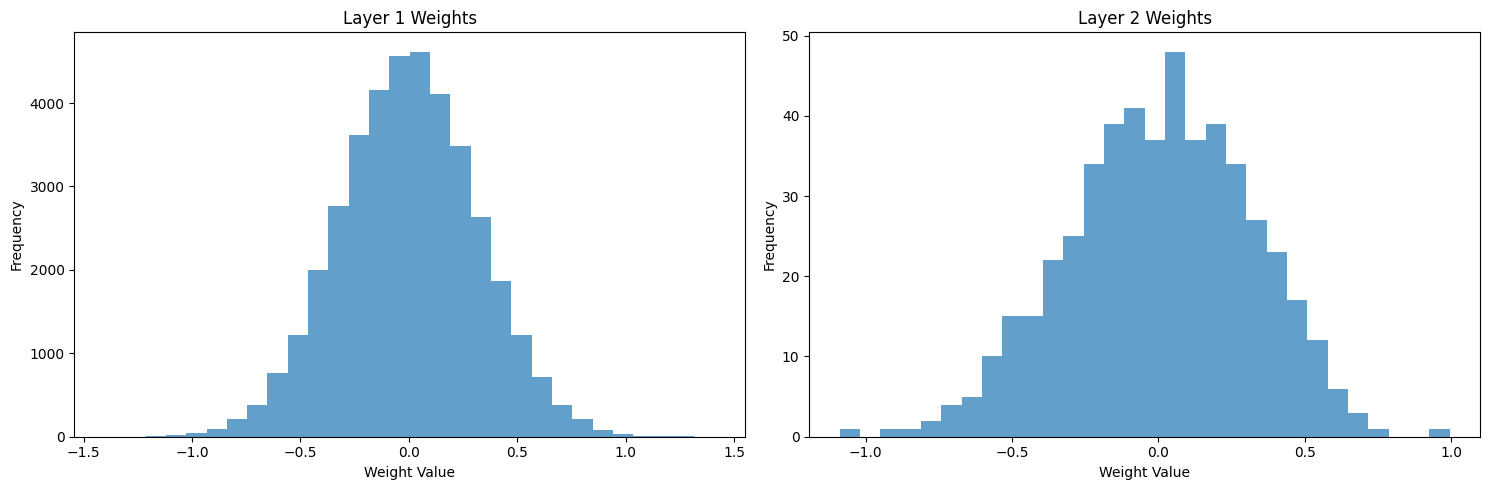

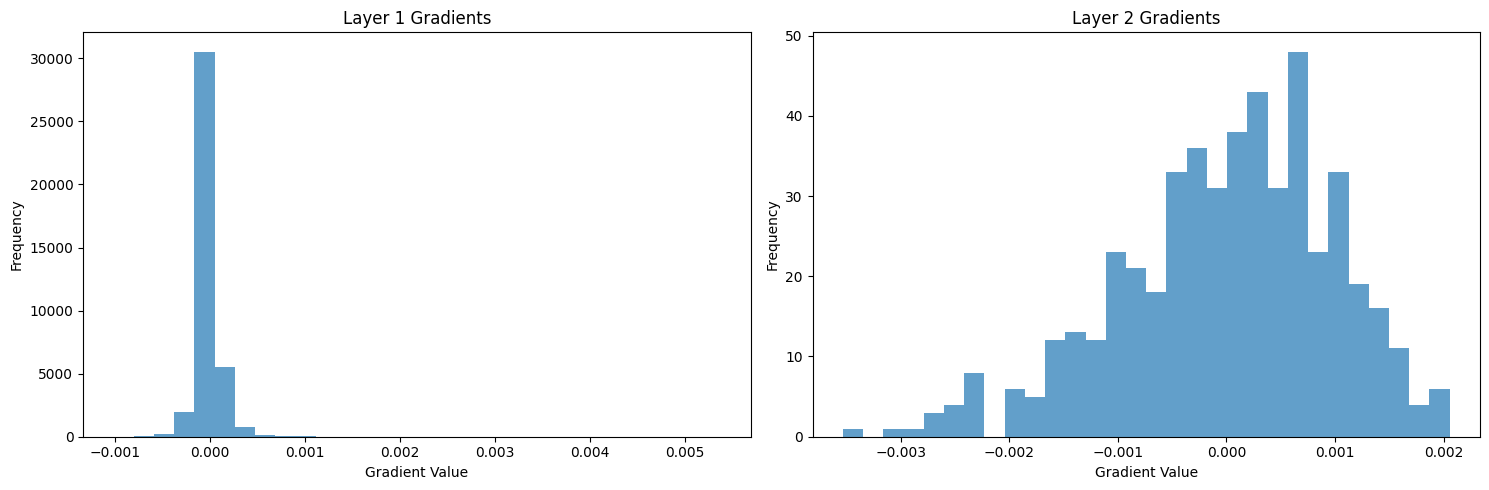

In [6]:
# Experiment 3: Learning Rate
def experiment_learning_rate():
    print("\nExperiment: Learning Rate")
    
    learning_rates = [0.001, 0.01, 0.1]
    lr_histories = {}
    lr_accuracies = {}
    lr_models = {}
    
    for lr in learning_rates:
        print(f"\nTraining network with learning rate = {lr}...")
        model = FFNN(
            layer_sizes=[784, 50, 10],
            activation_functions=["sigmoid", "softmax"],
            loss_function='categorical_crossentropy',
            weight_init_method='random_normal',
            weight_init_params={'mean': 0, 'variance': 0.1, 'seed': 42}
        )
        
        history = model.train(
            X_train, y_train_one_hot,
            X_val=X_test, y_val=y_test_one_hot,
            batch_size=32, learning_rate=lr,
            epochs=20, verbose=1
        )
        
        accuracy, _ = evaluate_model(model, X_test, y_test, y_test_one_hot)
        print(f"Learning rate {lr} accuracy: {accuracy:.4f}")
        
        lr_histories[lr] = history
        lr_accuracies[lr] = accuracy
        lr_models[lr] = model
    
    # Plot loss curves for different learning rates
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for lr, history in lr_histories.items():
        plt.plot(history['train_loss'], label=f"lr={lr} (train)")
    plt.title("Training Loss vs. Epochs (Different Learning Rates)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for lr, history in lr_histories.items():
        plt.plot(history['val_loss'], label=f"lr={lr} (val)")
    plt.title("Validation Loss vs. Epochs (Different Learning Rates)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 5))
    lrs = list(lr_accuracies.keys())
    accuracies = [lr_accuracies[lr] for lr in lrs]
    plt.bar([str(lr) for lr in lrs], accuracies)
    plt.title("Accuracy vs. Learning Rate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    # Plot weight and gradient distributions for each learning rate
    for lr, model in lr_models.items():
        print(f"\nWeight and gradient distributions for learning rate = {lr}:")
        
        # Plot weight distributions for all layers
        model.plot_weight_distribution()
        
        # Plot gradient distributions for all layers
        model.plot_gradient_distribution()
        
experiment_learning_rate()


Experiment: Weight Initialization

Training network with Zero initialization...
Epoch 1/20 - loss: 2.3023 - val_loss: 2.3003
Epoch 2/20 - loss: 2.3013 - val_loss: 2.2992
Epoch 3/20 - loss: 2.3008 - val_loss: 2.2985
Epoch 4/20 - loss: 2.3007 - val_loss: 2.2983
Epoch 5/20 - loss: 2.3005 - val_loss: 2.2982
Epoch 6/20 - loss: 2.3003 - val_loss: 2.2978
Epoch 7/20 - loss: 2.3002 - val_loss: 2.2978
Epoch 8/20 - loss: 2.3001 - val_loss: 2.2976
Epoch 9/20 - loss: 2.2999 - val_loss: 2.2974
Epoch 10/20 - loss: 2.2997 - val_loss: 2.2972
Epoch 11/20 - loss: 2.2995 - val_loss: 2.2969
Epoch 12/20 - loss: 2.2992 - val_loss: 2.2966
Epoch 13/20 - loss: 2.2990 - val_loss: 2.2964
Epoch 14/20 - loss: 2.2987 - val_loss: 2.2962
Epoch 15/20 - loss: 2.2984 - val_loss: 2.2956
Epoch 16/20 - loss: 2.2980 - val_loss: 2.2951
Epoch 17/20 - loss: 2.2976 - val_loss: 2.2947
Epoch 18/20 - loss: 2.2972 - val_loss: 2.2944
Epoch 19/20 - loss: 2.2967 - val_loss: 2.2937
Epoch 20/20 - loss: 2.2961 - val_loss: 2.2932
Zero ini

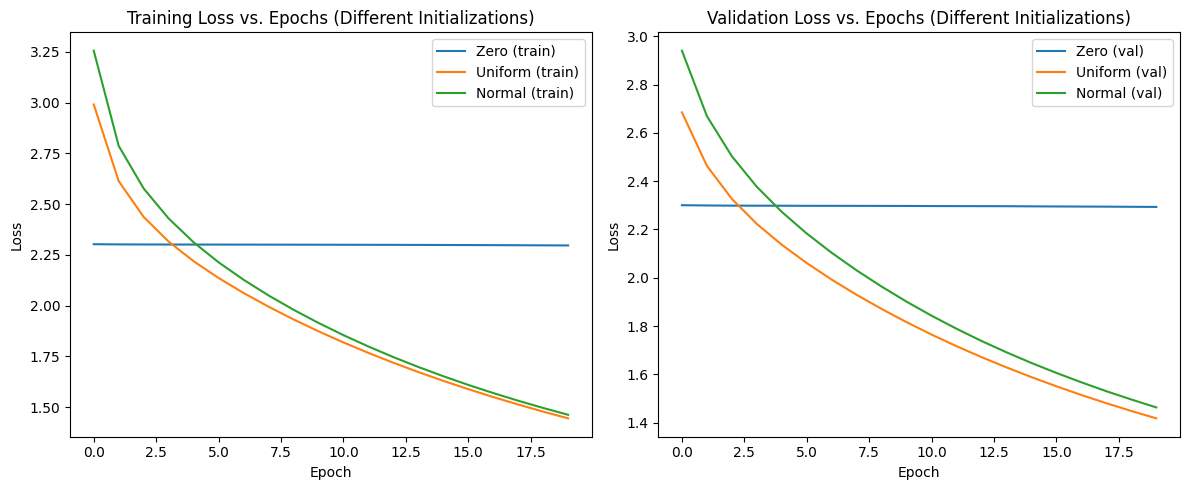

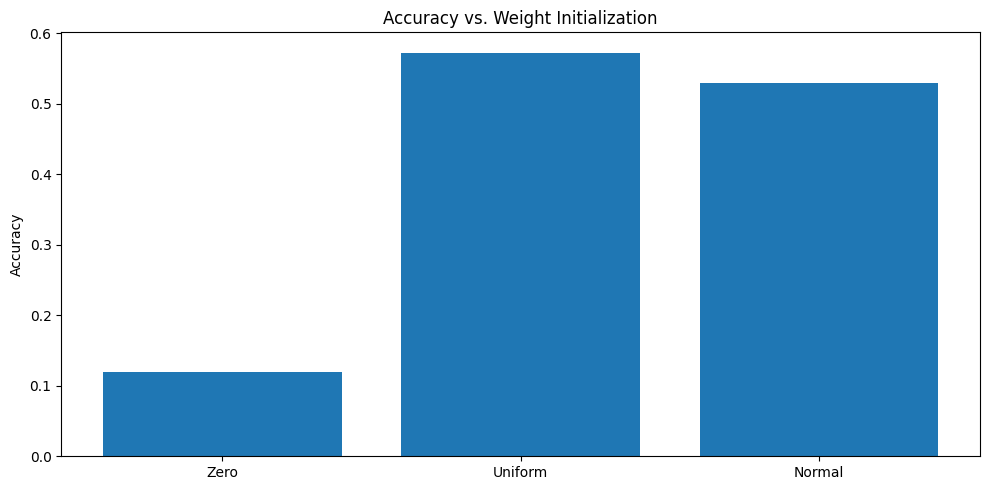


Weight distributions for Zero initialization:


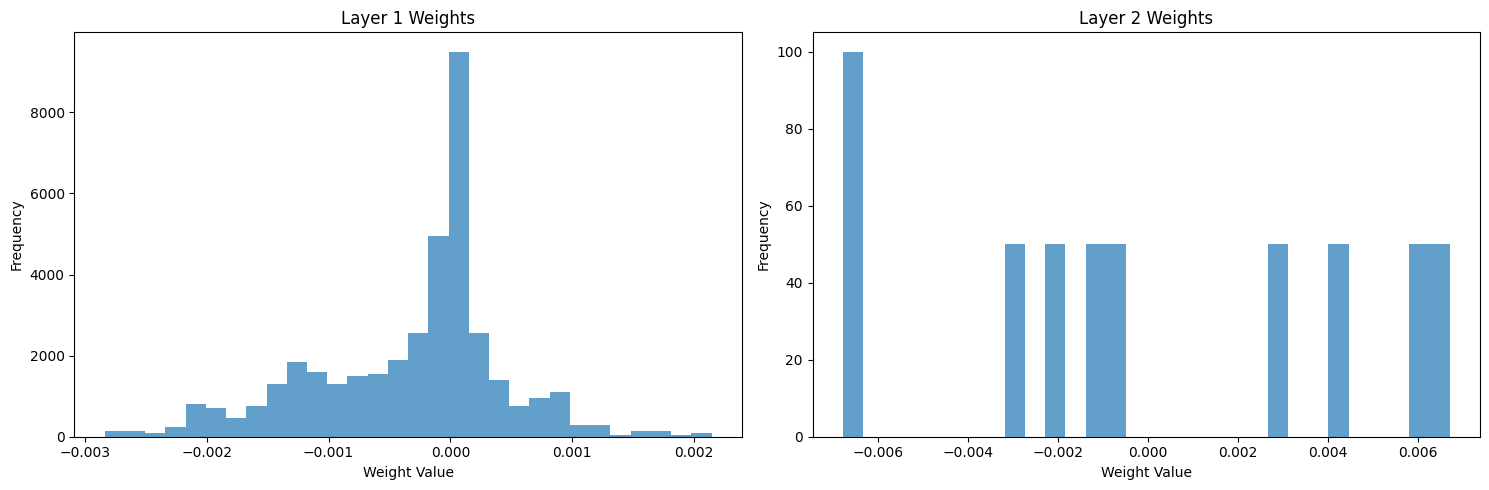


Weight distributions for Uniform initialization:


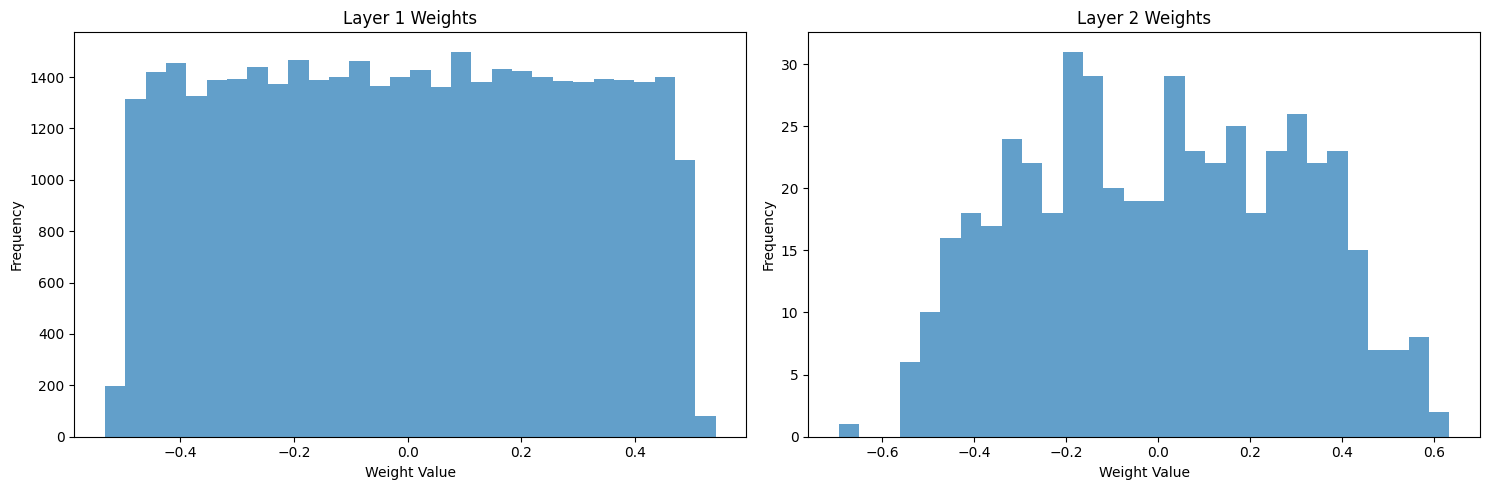


Weight distributions for Normal initialization:


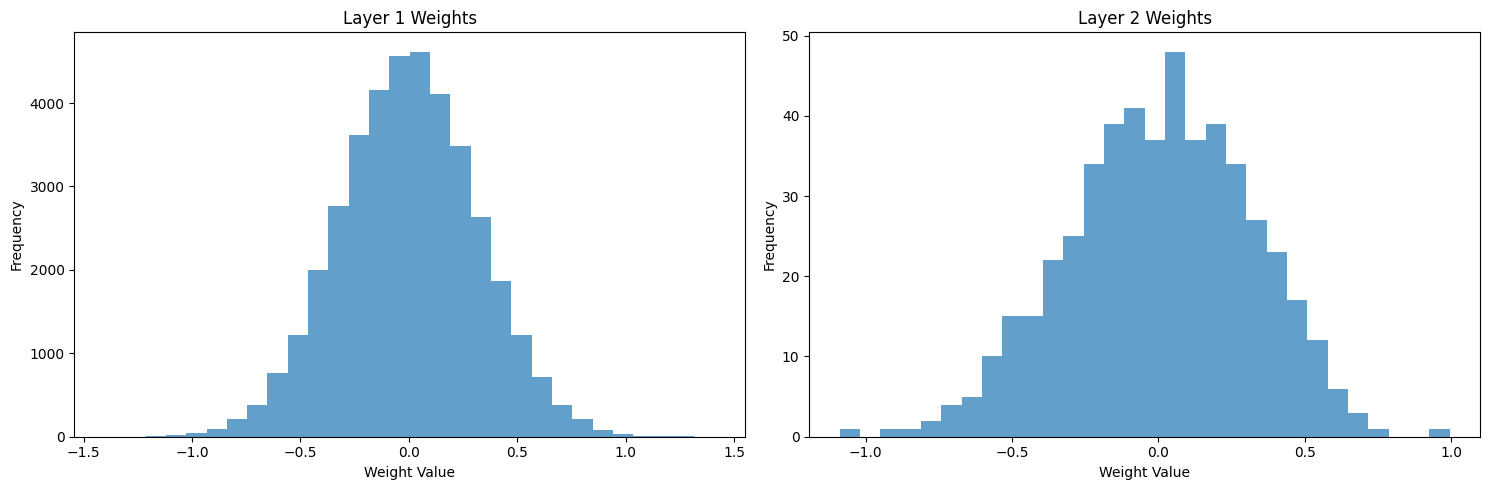

In [7]:
# Experiment 4: Weight Initialization
def experiment_weight_initialization():
    print("\nExperiment: Weight Initialization")
    
    init_configs = [
        {"name": "Zero", "method": "zero", "params": None},
        {"name": "Uniform", "method": "random_uniform", "params": {'lower_bound': -0.5, 'upper_bound': 0.5, 'seed': 42}},
        {"name": "Normal", "method": "random_normal", "params": {'mean': 0, 'variance': 0.1, 'seed': 42}}
    ]
    
    init_histories = {}
    init_accuracies = {}
    init_models = {}
    
    for config in init_configs:
        print(f"\nTraining network with {config['name']} initialization...")
        model = FFNN(
            layer_sizes=[784, 50, 10],
            activation_functions=["sigmoid", "softmax"],
            loss_function='categorical_crossentropy',
            weight_init_method=config['method'],
            weight_init_params=config['params']
        )
        
        history = model.train(
            X_train, y_train_one_hot,
            X_val=X_test, y_val=y_test_one_hot,
            batch_size=32, learning_rate=0.1,
            epochs=20, verbose=1
        )
        
        accuracy, _ = evaluate_model(model, X_test, y_test, y_test_one_hot)
        print(f"{config['name']} initialization accuracy: {accuracy:.4f}")
        
        init_histories[config['name']] = history
        init_accuracies[config['name']] = accuracy
        init_models[config['name']] = model
    
    # Plot loss curves for different initializations
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, history in init_histories.items():
        plt.plot(history['train_loss'], label=f"{name} (train)")
    plt.title("Training Loss vs. Epochs (Different Initializations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for name, history in init_histories.items():
        plt.plot(history['val_loss'], label=f"{name} (val)")
    plt.title("Validation Loss vs. Epochs (Different Initializations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 5))
    names = list(init_accuracies.keys())
    accuracies = [init_accuracies[name] for name in names]
    plt.bar(names, accuracies)
    plt.title("Accuracy vs. Weight Initialization")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    # Plot weight distributions for each initialization method
    for name, model in init_models.items():
        print(f"\nWeight distributions for {name} initialization:")
        model.plot_weight_distribution()
        
experiment_weight_initialization()


Experiment: Comparison with sklearn MLPClassifier
Training custom FFNN...
Epoch 1/20 - loss: 10.3765 - val_loss: 6.7469
Epoch 2/20 - loss: 4.9896 - val_loss: 4.2996
Epoch 3/20 - loss: 3.3493 - val_loss: 3.3158
Epoch 4/20 - loss: 2.5637 - val_loss: 2.7872
Epoch 5/20 - loss: 2.1005 - val_loss: 2.4792
Epoch 6/20 - loss: 1.7924 - val_loss: 2.2769
Epoch 7/20 - loss: 1.5833 - val_loss: 2.1069
Epoch 8/20 - loss: 1.4215 - val_loss: 2.0070
Epoch 9/20 - loss: 1.2913 - val_loss: 1.8939
Epoch 10/20 - loss: 1.1863 - val_loss: 1.8058
Epoch 11/20 - loss: 1.0999 - val_loss: 1.7618
Epoch 12/20 - loss: 1.0235 - val_loss: 1.6972
Epoch 13/20 - loss: 0.9549 - val_loss: 1.6434
Epoch 14/20 - loss: 0.8940 - val_loss: 1.6074
Epoch 15/20 - loss: 0.8435 - val_loss: 1.5665
Epoch 16/20 - loss: 0.7960 - val_loss: 1.5249
Epoch 17/20 - loss: 0.7546 - val_loss: 1.5250
Epoch 18/20 - loss: 0.7166 - val_loss: 1.4675
Epoch 19/20 - loss: 0.6809 - val_loss: 1.4647
Epoch 20/20 - loss: 0.6522 - val_loss: 1.4382
Custom FFNN a

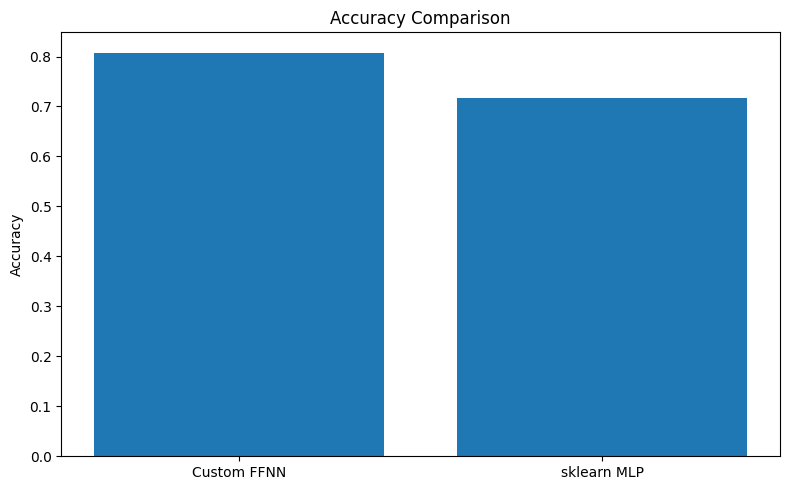

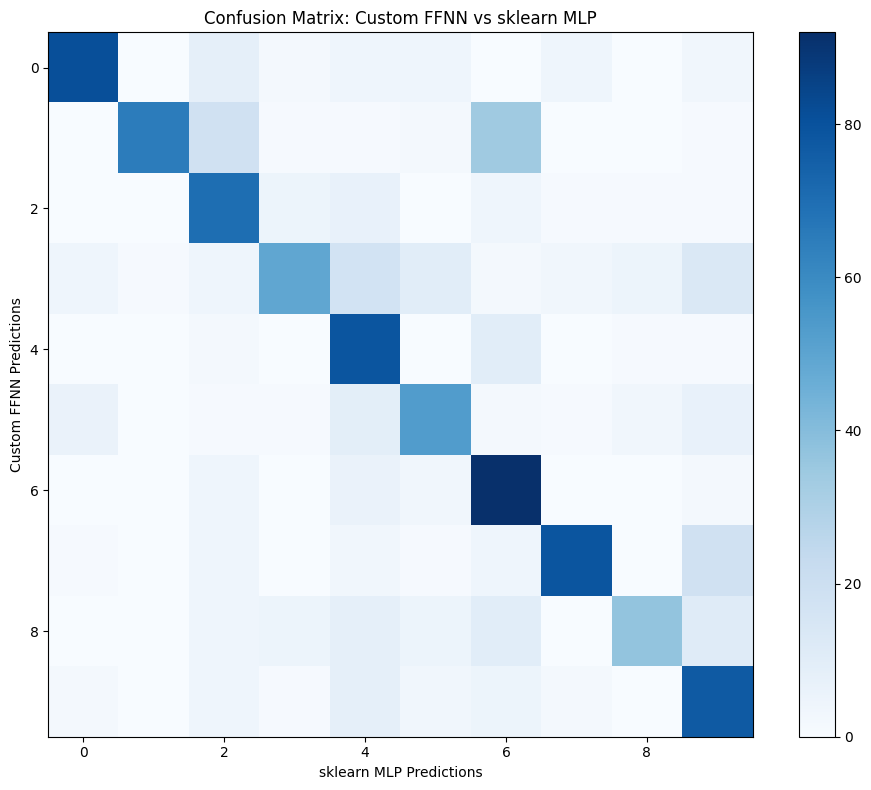

In [8]:
# Experiment 5: Compare with sklearn MLPClassifier
def experiment_sklearn_comparison():
    print("\nExperiment: Comparison with sklearn MLPClassifier")
    
    # Train our custom FFNN
    print("Training custom FFNN...")
    custom_model = FFNN(
        layer_sizes=[784, 50, 10],
        activation_functions=["relu", "softmax"],
        loss_function='categorical_crossentropy',
        weight_init_method='random_normal',
        weight_init_params={'mean': 0, 'variance': 0.1, 'seed': 42}
    )
    
    custom_history = custom_model.train(
        X_train, y_train_one_hot,
        X_val=X_test, y_val=y_test_one_hot,
        batch_size=32, learning_rate=0.1,
        epochs=20, verbose=1
    )
    
    custom_accuracy, custom_pred = evaluate_model(custom_model, X_test, y_test, y_test_one_hot)
    print(f"Custom FFNN accuracy: {custom_accuracy:.4f}")
    
    # Save custom FFNN model
    custom_model.save_model("../model/ffnn")
    
    # Train sklearn's MLPClassifier
    print("\nTraining sklearn MLPClassifier...")
    sklearn_model = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='sgd',
        alpha=0.0001,
        batch_size=32,
        learning_rate_init=0.1,
        max_iter=20*X_train.shape[1]//32,  # Equivalent to 20 epochs
        random_state=42
    )
    
    # Reshape data for sklearn
    sklearn_model.fit(X_train.T, y_train)
    
    sklearn_pred = sklearn_model.predict(X_test.T)
    sklearn_accuracy = accuracy_score(y_test, sklearn_pred)
    print(f"sklearn MLPClassifier accuracy: {sklearn_accuracy:.4f}")
    
    # Compare accuracies
    plt.figure(figsize=(8, 5))
    plt.bar(['Custom FFNN', 'sklearn MLP'], [custom_accuracy, sklearn_accuracy])
    plt.title("Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()
    
    # Compare predictions
    confusion_matrix = np.zeros((10, 10))
    for i in range(len(custom_pred)):
        confusion_matrix[int(custom_pred[i]), int(sklearn_pred[i])] += 1
    
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.colorbar()
    plt.title("Confusion Matrix: Custom FFNN vs sklearn MLP")
    plt.xlabel("sklearn MLP Predictions")
    plt.ylabel("Custom FFNN Predictions")
    plt.tight_layout()
    plt.show()
    
experiment_sklearn_comparison()